In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
import cv2

In [3]:
def abrir_imagem(img_caminho):

    imagem = cv2.imread(img_caminho)

    if imagem is None:
        raise NameError("O OpenCV não conseguiu abrir a imagem, verifique o caminho.")

    return imagem

In [4]:
caminho_absoluto = lambda nome_imagem: "My Drive/Curso-OMR/images-test/"+nome_imagem
nome_imagem = "teste0.png"
imagem = abrir_imagem(caminho_absoluto(nome_imagem))

R - red

G - green

B - blue

Gray

In [5]:
img_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

thres, img_binaria = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

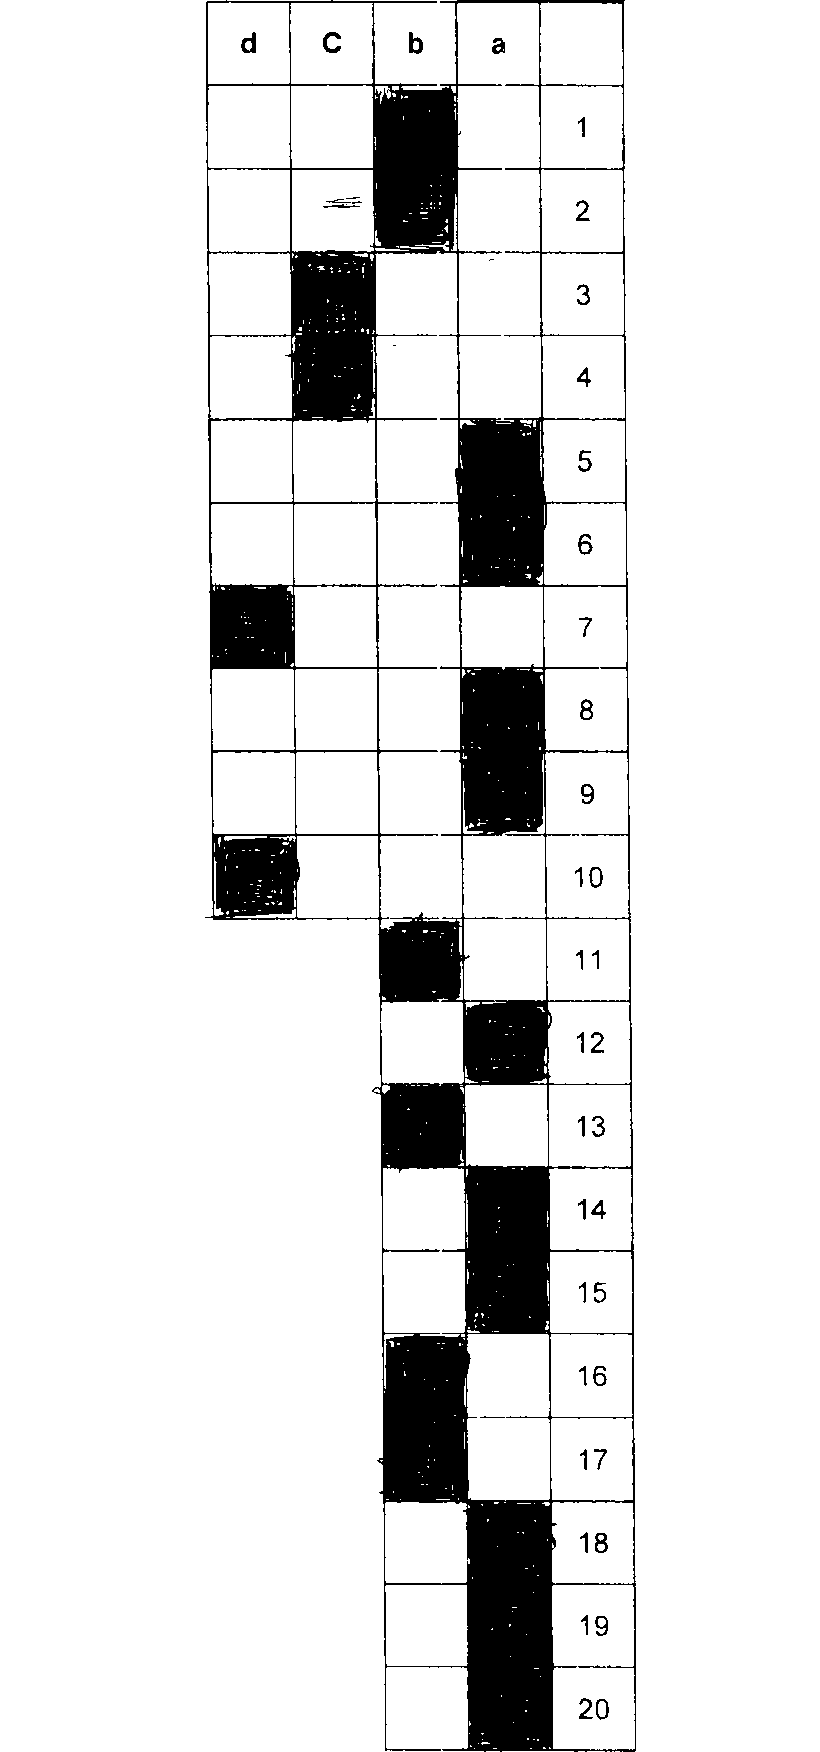

In [6]:
from google.colab.patches import cv2_imshow

cv2_imshow(img_binaria)

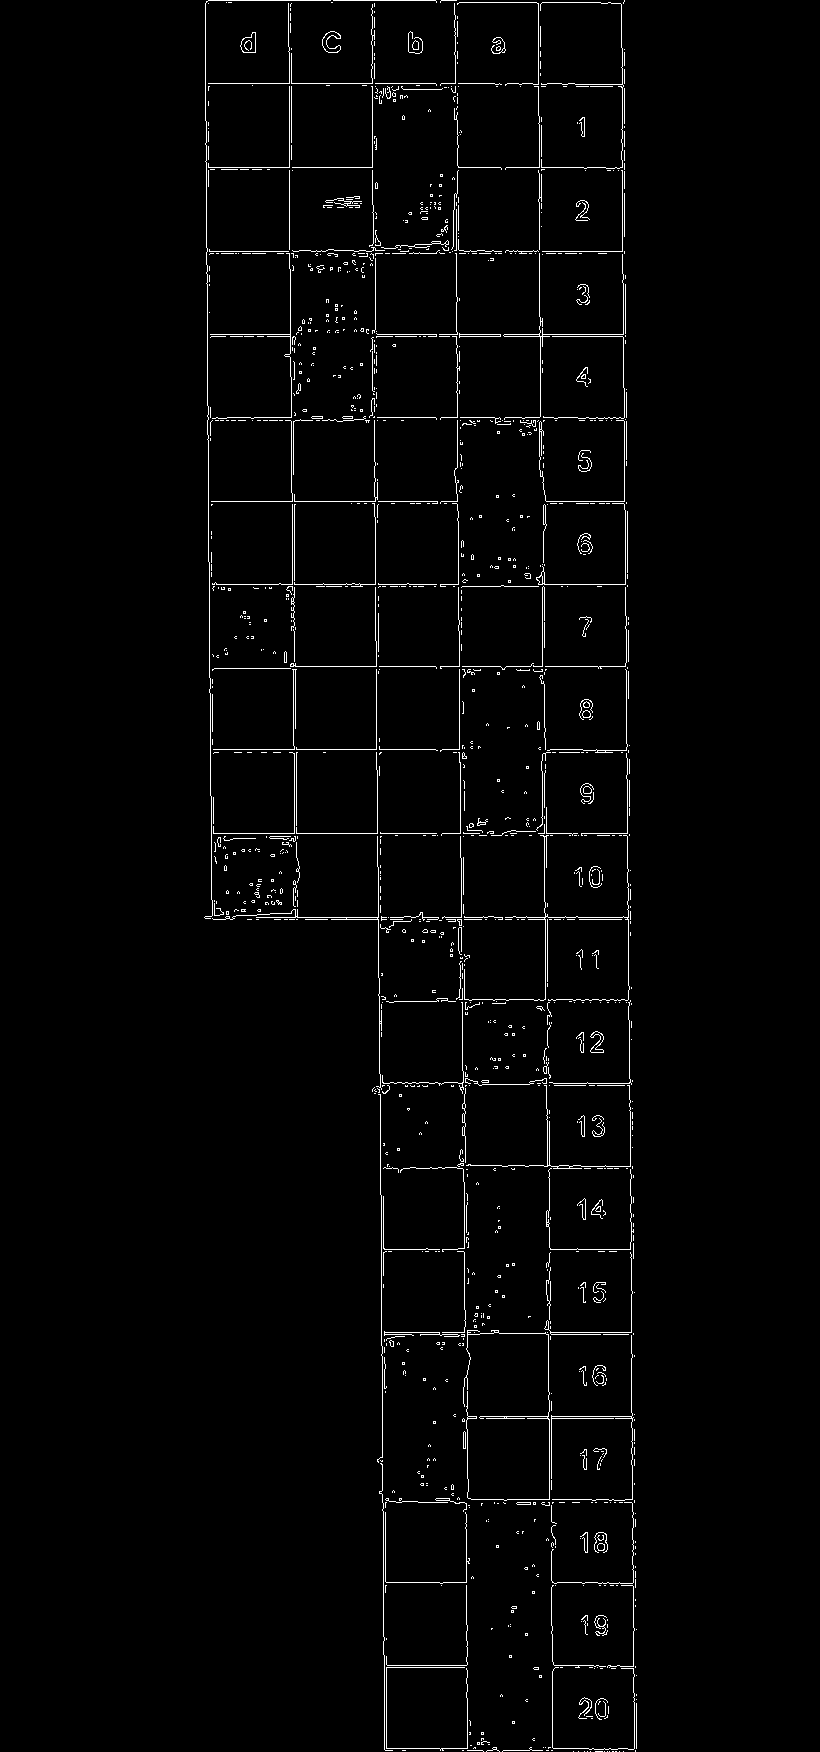

In [7]:
canny = cv2.Canny(img_binaria, 100, 200)

cv2_imshow(canny)

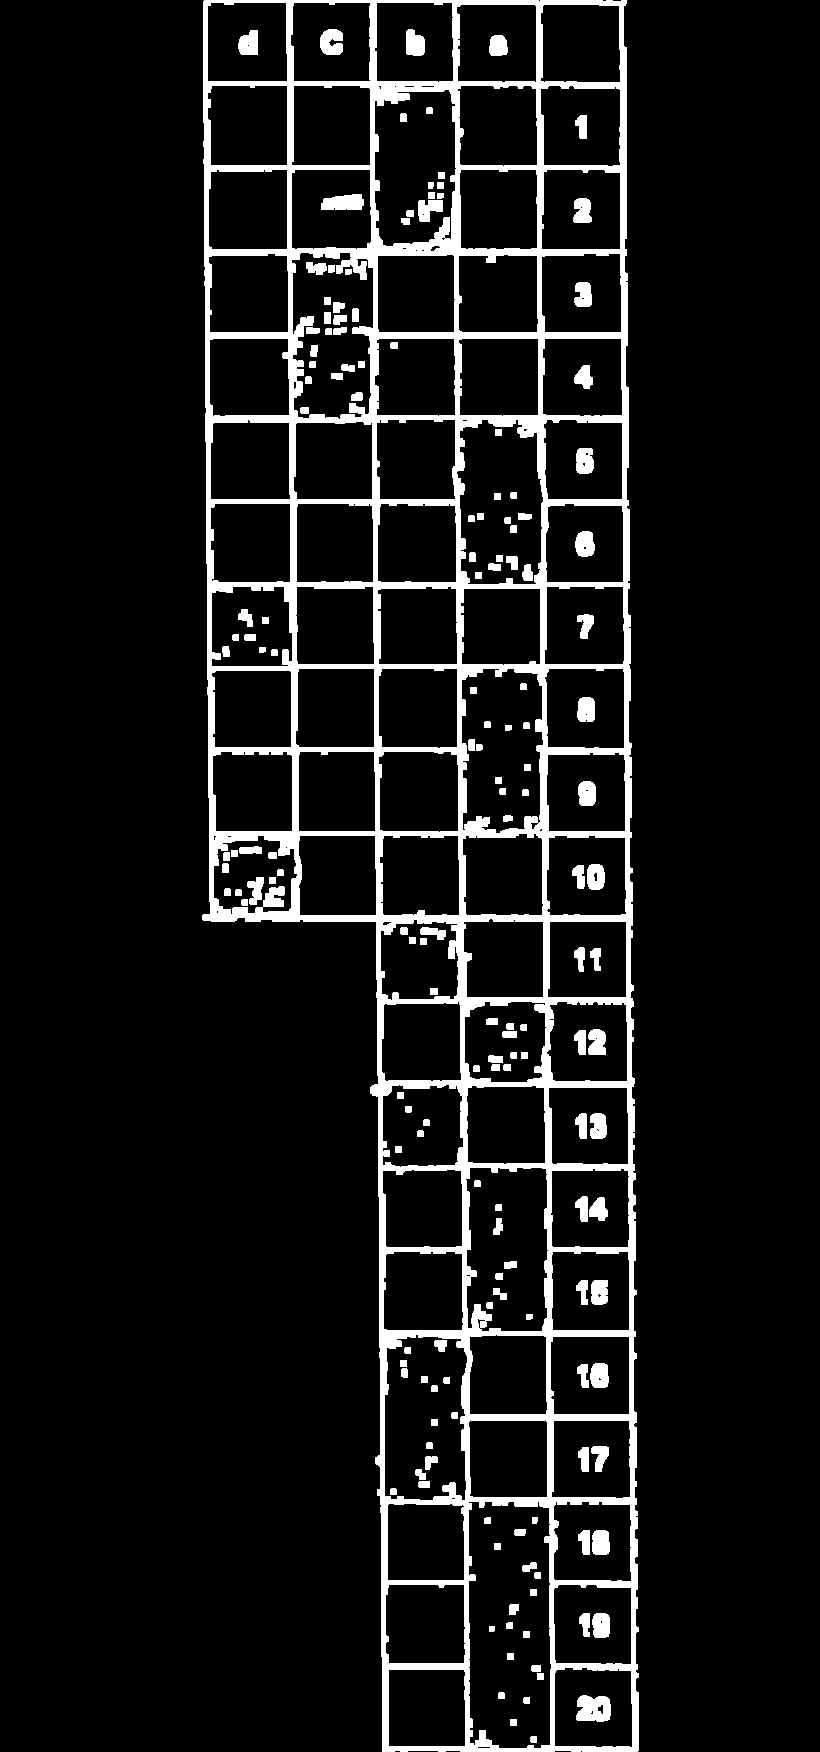

In [8]:
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
operacao_dilatar = cv2.morphologyEx(canny, cv2.MORPH_DILATE, kernel_rect)

cv2_imshow(operacao_dilatar)

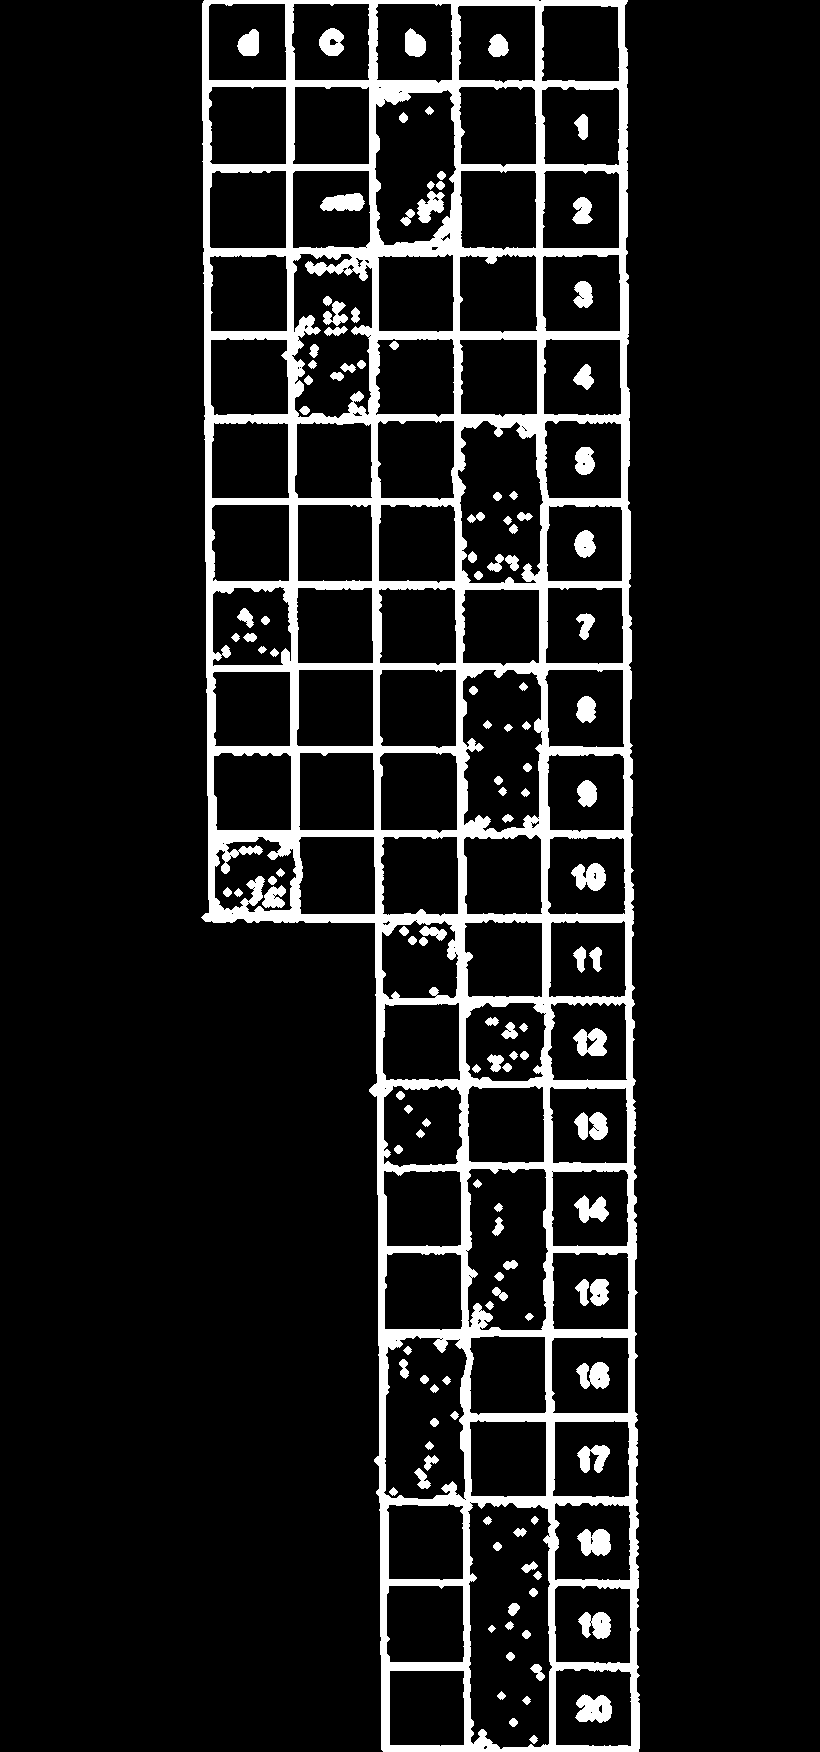

In [9]:
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
operacao_dilatar = cv2.morphologyEx(canny, cv2.MORPH_DILATE, kernel_cross, iterations = 3)

#print(kernel_cross)
cv2_imshow(operacao_dilatar)

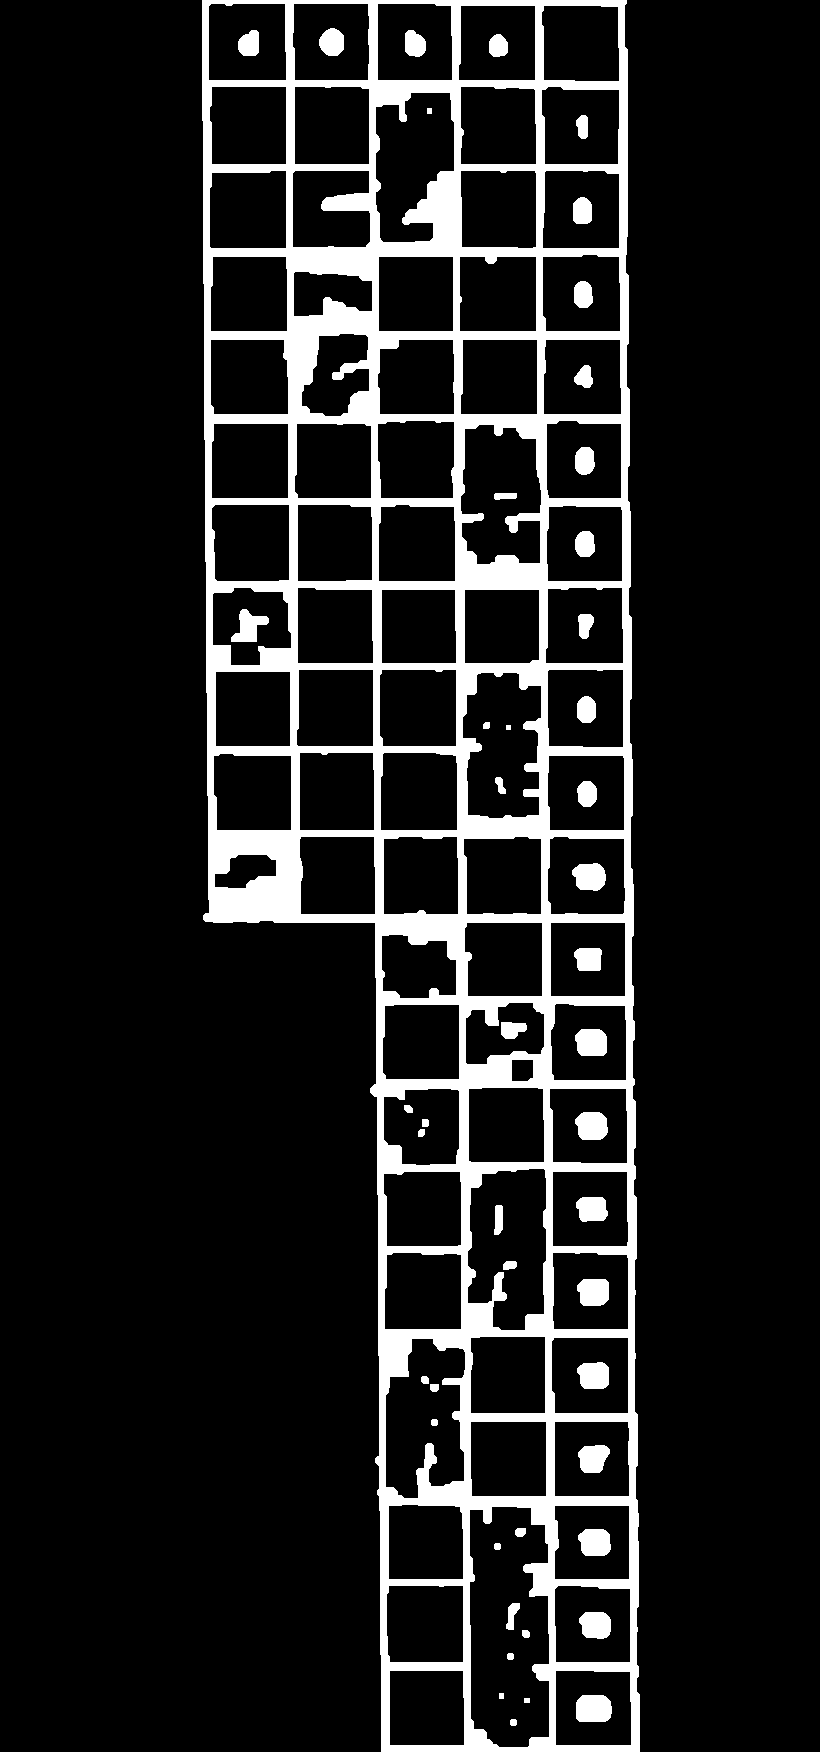

In [10]:
operacao_close = cv2.morphologyEx(operacao_dilatar, cv2.MORPH_CLOSE, kernel_rect, iterations=3)

operacao_open = cv2.morphologyEx(operacao_close, cv2.MORPH_OPEN, kernel_rect, iterations = 1)
cv2_imshow(operacao_open)

In [11]:
import math

def hough_para_cartesiano(raio, theta):

    seno = math.sin(theta)
    cosseno = math.cos(theta)

    x = raio*cosseno
    y = raio*seno

    return (x,y)

In [12]:
def criar_linha(ponto, theta):

    seno = math.sin(theta)
    cosseno = math.cos(theta)

    x1 = int(ponto[0] + 10000*(-seno))
    y1 = int(ponto[1] + 10000*(cosseno))

    x2 = int(ponto[0] - 800*(-seno))
    y2 = int(ponto[1] - 800*(cosseno))

    return (x1,y1,x2,y2)

In [13]:
def desenhar_linha(img, raio, theta):
    ponto = hough_para_cartesiano(raio,theta)
    x1,y1,x2,y2 = criar_linha(ponto, theta)
    img = cv2.line(img, (x1,y1), (x2,y2), (0,255,0),3)

    return img

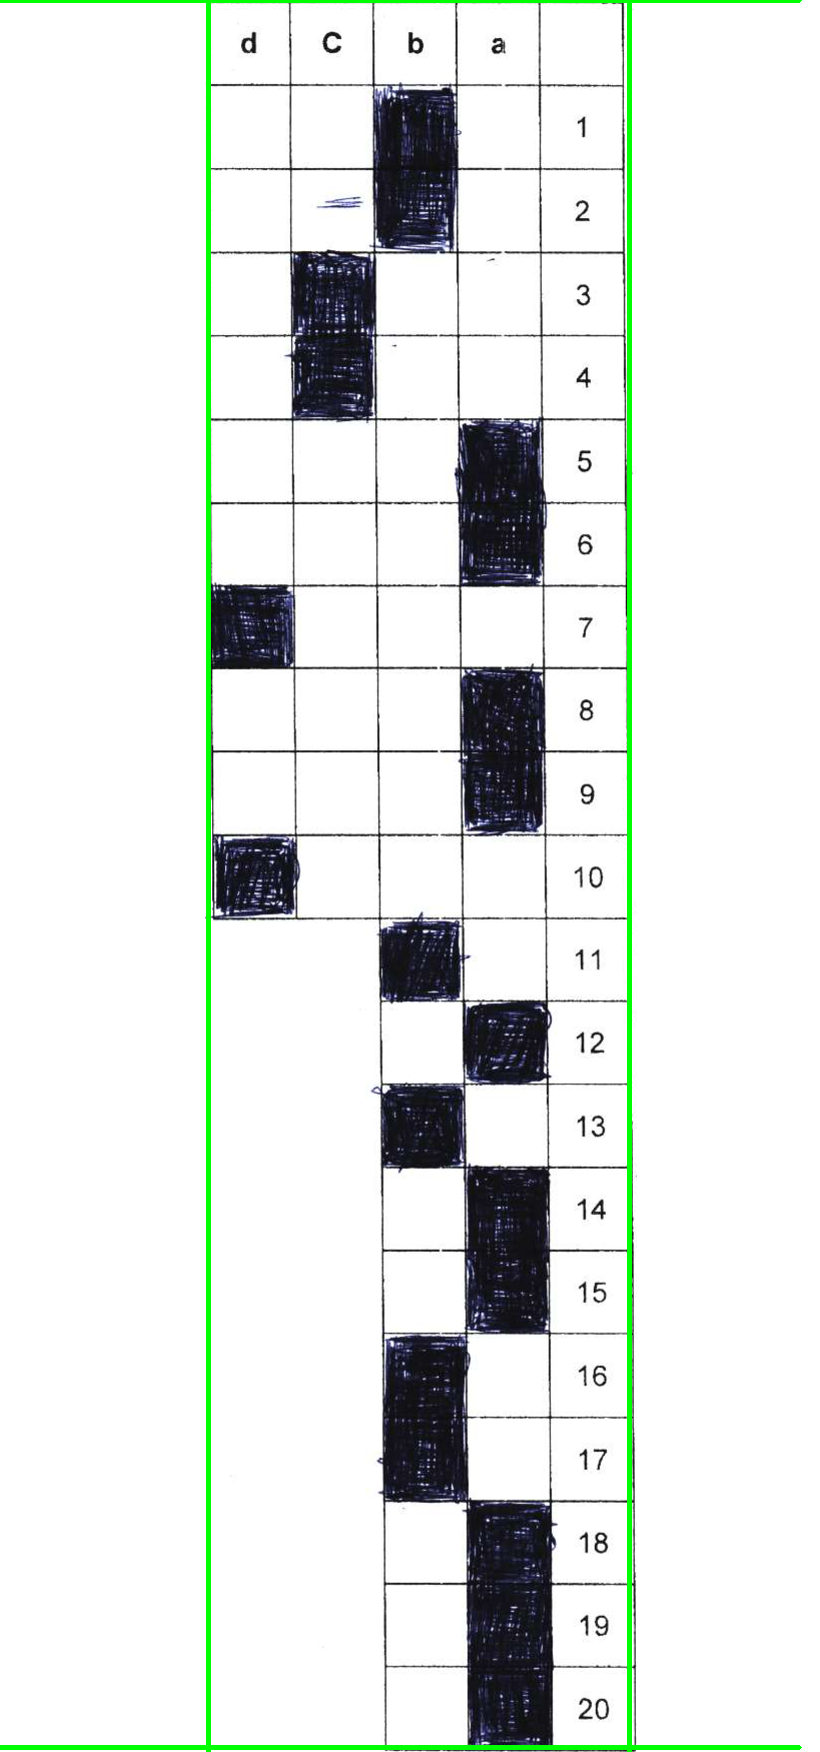

In [14]:
import numpy as np

l_linhas = cv2.HoughLines(operacao_open, 1, np.pi/180, 80)

limites_horizontais = np.array([
                                [imagem.size, imagem.size], #MENOR (raio,theta)
                                [0.0,0.0]], dtype=np.float #MAIOR (raio,theta)
                            )

limites_verticais = np.array([
                                [imagem.size, imagem.size], #MENOR (raio, theta)
                                [0.0,0.0]], dtype=np.float #MAIOR (raio,theta)
                            )

for linha in l_linhas:
    for raio, theta in linha:

        if np.isclose(theta,0.0): # linha vertical
            
            if raio<limites_verticais[0][0]:
                limites_verticais[0][0] = raio
                limites_verticais[0][1] = theta
            
            if raio>limites_verticais[1][0]:
                limites_verticais[1][0] = raio
                limites_verticais[1][1] = theta

        if np.isclose(theta,np.pi/2.0): # linha horizontal

            if raio<limites_horizontais[0][0]:
                limites_horizontais[0][0] = raio
                limites_horizontais[0][1] = theta

            if raio>limites_horizontais[1][0]:
                limites_horizontais[1][0] = raio
                limites_horizontais[1][1] = theta

imagem_copia = imagem.copy() 

for valor in range(2): # 0 1
      
    imagem_copia = desenhar_linha(imagem_copia, limites_horizontais[valor][0], limites_horizontais[valor][1])

    image_copia = desenhar_linha(imagem_copia, limites_verticais[valor][0], limites_verticais[valor][1])

cv2_imshow(imagem_copia)

In [15]:
def encontrar_interseccao(raio1, raio2):

    resultante = math.sqrt((raio1**2+raio2**2))
    theta = math.atan((raio1/raio2))

    return resultante, theta

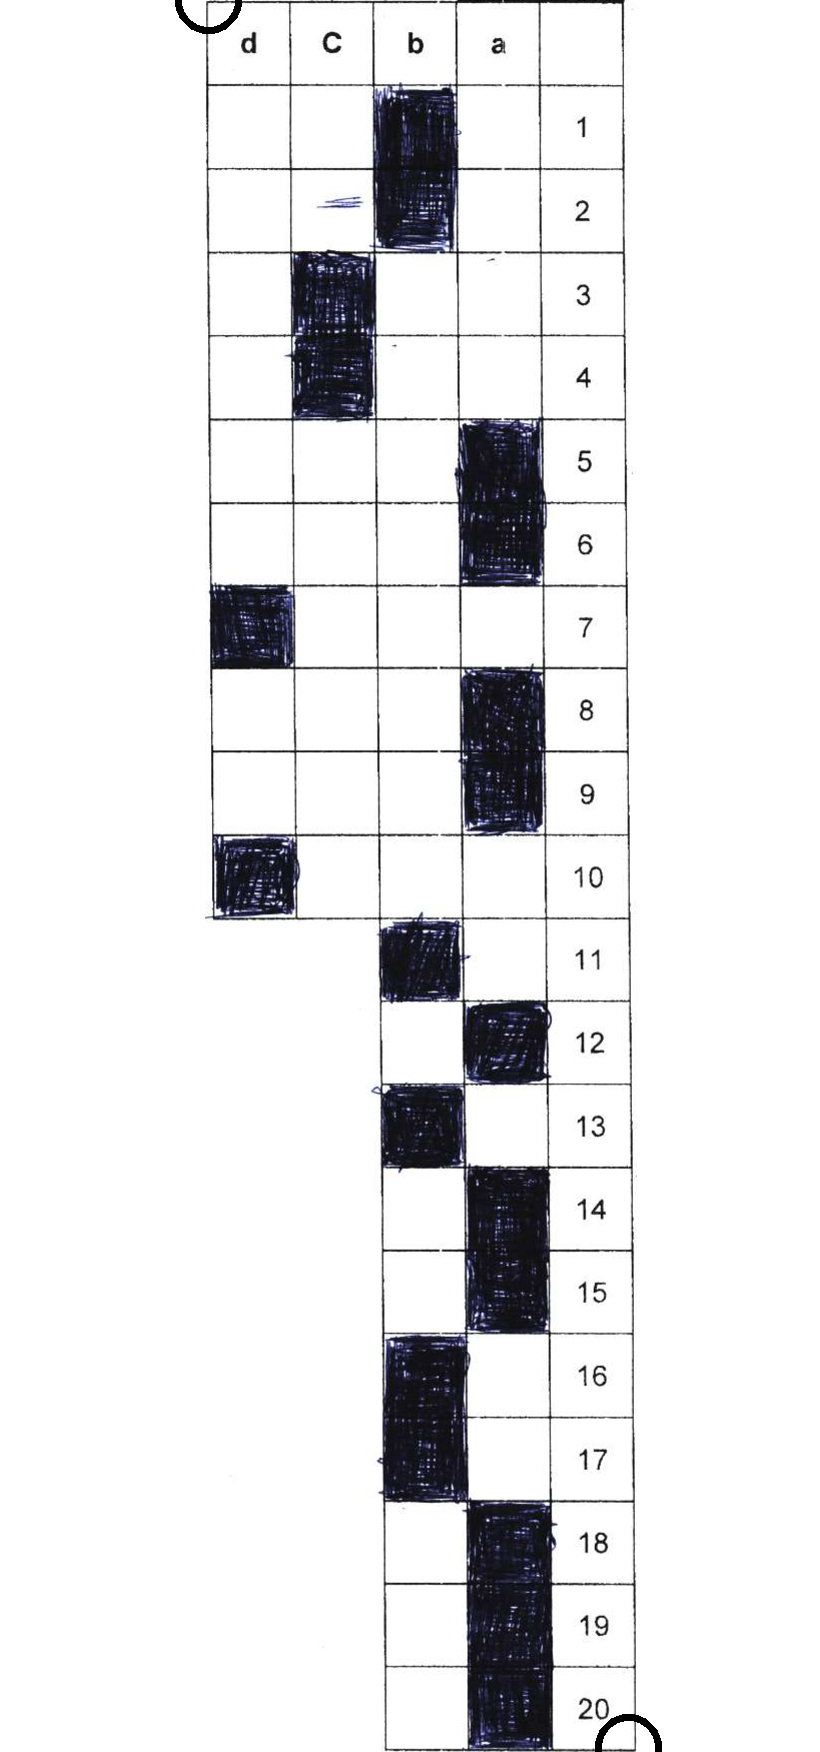

In [16]:
# ponto superior esquerdo (se)

raio_se, theta_se = encontrar_interseccao(limites_horizontais[0][0], limites_verticais[0][0])
x_se, y_se = hough_para_cartesiano(raio_se, theta_se)

# ponto inferior direito (id)

raio_id, theta_id = encontrar_interseccao(limites_horizontais[1][0], limites_verticais[1][0])
x_id, y_id = hough_para_cartesiano(raio_id, theta_id)

img_copia = imagem.copy()

cv2.circle(img_copia, (int(x_se), int(y_se)), 30, (0,0,0), 5)
cv2.circle(img_copia, (int(x_id), int(y_id)), 30, (0,0,0), 5)

cv2_imshow(img_copia)

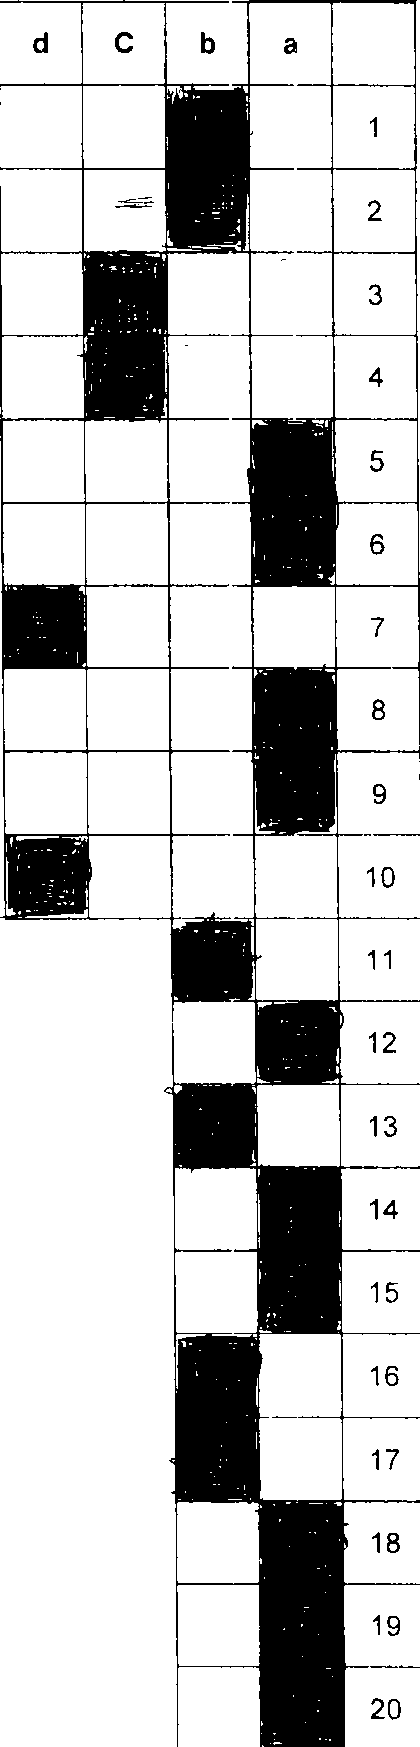

In [17]:
nova_imagem = img_binaria[int(y_se):int(y_id), int(x_se):int(x_id)]

cv2_imshow(nova_imagem)

In [ ]:
QTD_QUESTAO = 21
QTD_ALTERNATIVA = 5

def get_resposta(imagem, questao_numero):

    map_indice = {3:'a', 2:'b', 1:'c', 0:'d'}
    espacamento_questao = imagem.shape[0]/QTD_QUESTAO
    espacamento_alternativa = imagem.shape[1]/QTD_ALTERNATIVA

    inicio_questao = int(questao_numero*espacamento_questao)
    fim_questao = int((questao_numero+1)*espacamento_questao)

    questao = imagem[inicio_questao:fim_questao, :]

    respostas = np.empty(4)
    for alternativa in range(QTD_ALTERNATIVA-1):
        inicio_alternativa = int(alternativa*espacamento_alternativa)
        fim_alternativa = int((alternativa+1)*espacamento_alternativa)

        respostas[alternativa] = np.mean(questao[:,inicio_alternativa:fim_alternativa])

    indice = np.where(respostas == np.amin(respostas))[0][0]

    return map_indice[indice]


In [30]:
def corrige(imagem):
    respostas = {}
    for questao in range(1, QTD_QUESTAO):
        respostas[questao] = get_resposta(imagem, questao)

    return respostas

In [31]:
correcao = corrige(nova_imagem)
print(correcao)

{1: 'b', 2: 'b', 3: 'c', 4: 'c', 5: 'a', 6: 'a', 7: 'd', 8: 'a', 9: 'a', 10: 'd', 11: 'b', 12: 'a', 13: 'b', 14: 'a', 15: 'a', 16: 'b', 17: 'b', 18: 'a', 19: 'a', 20: 'a'}
